In [37]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [38]:
# Global variables, hyperparameters (alpha = inverse aplha)
N_data = 30
alpha = 0.01
beta = 0.01

In [39]:
# Toy data
X = tf.transpose(tf.constant([[0.02, 0.12, 0.145, 0.1654, 0.143,
                               0.1123, 0.21, 0.145, 0.167, 0.1456,
                               0.186, 0.145, 0.134, 0.81, 0.82, 0.832,
                               0.811, 0.842, 0.8234, 0.885, 0.9, 0.91,
                               0.93, 0.933, 0.03, 0.98, 0.81234, 0.79,
                               0.099, 0.0988]]))
Y = 0.5 * tf.math.sin(3*X) + tf.random.normal((N_data, 1), 0, 0.01)

In [40]:
# Model architecture
model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(128, activation='tanh', name='dense_2'),
        tf.keras.layers.Dense(64, activation='tanh', name='dense_3'),
        tf.keras.layers.Dense(32, activation='tanh', name='dense_4'),
        tf.keras.layers.Dense(1, activation='linear', name='dense_6')
        ])

In [41]:
# Loss function (mean squeare error + L2)
def compute_loss(Y, y_output):
   least_sq = tf.reduce_mean(tf.math.squared_difference(y_output, Y))
   loss = least_sq + least_sq * tf.add_n([tf.norm(x)**2 for x in model.trainable_weights])
   return loss

In [42]:
# Weights maximum a posteriori calculation
model.compile(optimizer = 'adam', loss = compute_loss, metrics = ['mse'])

model.fit(X, Y, epochs = 500, batch_size = int(N_data / 10))

W_MAP = model.trainable_weights

Train on 30 samples
Epoch 1/500
30/30 [==============================] - 0s 10ms/sample - loss: 1.6993 - mse: 0.0128
Epoch 2/500
30/30 [==============================] - 0s 367us/sample - loss: 1.3602 - mse: 0.0104
Epoch 3/500
30/30 [==============================] - 0s 440us/sample - loss: 0.8201 - mse: 0.0063
Epoch 4/500
30/30 [==============================] - 0s 430us/sample - loss: 0.7358 - mse: 0.0057
Epoch 5/500
30/30 [==============================] - 0s 421us/sample - loss: 0.9013 - mse: 0.0071
Epoch 6/500
30/30 [==============================] - 0s 381us/sample - loss: 0.7533 - mse: 0.0059
Epoch 7/500
30/30 [==============================] - 0s 326us/sample - loss: 0.8118 - mse: 0.0064
Epoch 8/500
30/30 [==============================] - 0s 428us/sample - loss: 1.0478 - mse: 0.0084
Epoch 9/500
30/30 [==============================] - 0s 397us/sample - loss: 0.6948 - mse: 0.0056
Epoch 10/500
30/30 [==============================] - 0s 317us/sample - loss: 0.7071 - mse: 0.0057


In [36]:
# Energy function hessian calculation
weights_num = np.sum([np.prod(v.get_shape().as_list()) for v in model.trainable_weights])
A = 1/(beta*alpha) * tf.eye(weights_num)
for index, x in enumerate(X):    
    with tf.GradientTape() as t:
        y = model(tf.reshape([x], (1,1)))
    grad = t.gradient(y, W_MAP)
    flat = tf.concat([tf.reshape(tensor, (-1, 1)) for tensor in grad], axis = 0)
    A = A - (A @ flat @ tf.transpose(flat)  @ A)/(1+tf.transpose(flat) @ A @ flat)
    print(index)
A = beta * A

In [32]:
# Standard deviation calculation
def compute_sigma(x, beta):
    with tf.GradientTape() as t:
        y = model(tf.Variable([[x]], (1, 1)))
    grad = t.gradient(y, W_MAP)
    flat = tf.concat([tf.reshape(tensor, (-1, 1)) for tensor in grad], axis = 0)
    sigma = beta + tf.transpose(flat) @ A @ flat
    return sigma

x_plot = np.arange(-0.3, 1.3, 0.01)
pred = model.predict(x_plot)
x_plot = [x for x in x_plot]

sigma_pred = [compute_sigma(x_p, beta) for x_p in x_plot]

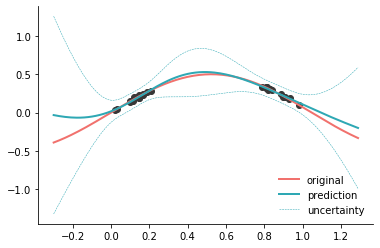

In [33]:
# Visualization
fig, ax = plt.subplots()
ax.plot(x_plot, [0.5 * np.sin(3 * i) for i in x_plot], color = '#f1716d', linewidth = 2.0, label = 'original')
ax.plot(x_plot, pred, color = "#2ea8b4", linewidth = 2.0, label = 'prediction')
ax.plot(x_plot, pred.reshape(1,-1)[0] + [np.sqrt(x.numpy().item()) for x in sigma_pred],
         color = '#2ea8b4', linestyle = 'dashed', linewidth = 0.5, label = 'uncertainty')
ax.plot(x_plot, pred.reshape(1,-1)[0] - [np.sqrt(x.numpy().item()) for x in sigma_pred],
         color = '#2ea8b4', linestyle = 'dashed', linewidth = 0.5)
ax.scatter(X, Y, color = '#373737')
ax.legend(loc = 'lower right', frameon = False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)